# Predecir los ingresos futuros de las aerolíneas a partir de fuentes de datos alternativas

## Introducción (5 min)

**Contexto empresarial.** Usted es un analista de investigación de un gran banco de inversión. Su equipo se especializa en analizar la industria de las aerolíneas y predecir los ingresos y costos futuros para que puedan recomendar estrategias de inversión a sus clientes. Después de haber completado la capacitación en ciencia de datos, está ansioso por aplicar sus habilidades recién adquiridas al problema. Su equipo ya tiene muchos datos en este dominio, pero cree que hay datos adicionales que pueden usarse para desarrollar mejores predicciones. Sus datos disponibles están actualizados hasta enero de 2020 y su objetivo es predecir las próximas ganancias trimestrales que se obtendrán en febrero de 2020.

**Problema comercial.** Su tarea es **crear un modelo para predecir los ingresos futuros de United Airlines **

**Contexto analítico.** Como parte de una gran empresa de servicios financieros, los siguientes datos ya se han recopilado y están en uso para su equipo:

1. El archivo **"airline_revenues.csv"** contiene el historial de ingresos trimestrales de las principales aerolíneas de EE. UU.
2. El archivo **"airline_fuel_cost.csv"** contiene el historial de costos de combustible de todas las principales aerolíneas de EE. UU.
3. El archivo **"oil.csv"** contiene el historial de precios de diferentes productos derivados del petróleo.

También ha estado buscando datos adicionales para mejorar su modelo. Después de considerar muchas fuentes diferentes, está principalmente interesado en:

1. Bureau of Transportation Statistics (**BTS**), que contiene información aparentemente pertinente para el problema
2. Twitter, que tiene medidas de densidad de tweets como algún tipo de proxy para la cantidad de pasajeros

El caso procederá de la siguiente manera: usted (1) analizará los datos actuales de su equipo y evaluará sus deficiencias; (2) investigar fuentes de datos alternativas; (3) extraer los datos de estas fuentes y realizar limpieza de datos, EDA e ingeniería de características; y finalmente (4) crear un modelo predictivo.

In [ ]:
## Paquetes

import time

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns


from datetime import datetime
from geopy.geocoders import Nominatim
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Analizar la data existente

Antes de sumergirnos en cualquier proyecto de ciencia de datos, nuestro primer paso siempre debe ser evaluar los datos actuales para comprender qué piezas de información podrían faltar. En algunos casos, no tendrá datos y tendrá que empezar de cero. Aquí, ya tenemos 3 fuentes de datos diferentes, por lo que debemos analizar cada una de ellas individualmente y todas como un todo para averiguar cómo exactamente debemos complementarlas. En cada etapa, debemos tener en cuenta nuestro objetivo: **predecir los ingresos futuros**. Eso significa que deberíamos pensar en la siguiente pregunta: **"¿Qué información sería útil para predecir los ingresos de la aerolínea?"**.


Veamos primero los datos de ingresos de la aerolínea. Importaremos el archivo y visualizaremos los datos:

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
# Establecer ruta de acceso en drive
import os
print(os.getcwd())
os.chdir("/content/gdrive/My Drive")

Mounted at /content/gdrive
/content


In [ ]:
%cd '/content/gdrive/MyDrive/Bootcamp SENA 2021/Semana 10/'

/content/gdrive/MyDrive/Bootcamp SENA 2021/Semana 10


In [ ]:
airline_revenues = pd.read_csv('airline_revenues.csv')
airline_revenues

UNIQUE_CARRIER  YEAR  MONTH  ...  NET_EARNINGS  EPS_BASIC  EPS_DILUTED
0               AS  2006      3  ...         -79.1      -2.36        -2.36
1               AS  2006      6  ...          55.5       1.46         1.38
2               AS  2006      9  ...         -17.4      -0.44        -0.44
3               AS  2006     12  ...         -11.6      -0.29        -0.29
4               AS  2007      3  ...         -10.3      -0.26        -0.26
..             ...   ...    ...  ...           ...        ...          ...
478             UA  2018      9  ...         836.0       3.07         3.06
479             UA  2018     12  ...         462.0       1.71         1.70
480             UA  2019      3  ...         292.0       1.09         1.09
481             UA  2019      6  ...        1052.0       4.03         4.02
482             UA  2019      9  ...        1024.0       4.01         3.99

[483 rows x 9 columns]

Los features de la data son:

- **UNIQUE_CARRIER**: La aerolínea que presentó los ingresos trimestrales
- **YEAR**: año
- **MONTH**: mes
- **DAY**: dia
- **REVENUE**: Ingresos reportados (en millones)
- **PROFIT**: Beneficio informado (beneficio = ingresos - costes; en millones)
- **NET_EARNINGS**:Ganancias reportadas (ganancias menos impuestos, intereses y amortización; en millones)
- **EPS_BASIC**:Ganancias por acción
- **EPS_DILUTED**: Beneficio por acción después de la dilución

Solo estamos interesados en United porque queremos demostrar que este modelo predictivo funciona para una aerolínea como prueba de concepto antes de construir un modelo más general. Como eres nuevo en el equipo, no estás seguro de cuál es el código de United, por lo que buscas la documentación relevante y ves que es **UA**. Como solo nos interesan los ingresos, simplifiquemos este DataFrame:

In [ ]:
#Solo lo de United
united_revenues = airline_revenues[airline_revenues['UNIQUE_CARRIER'] == 'UA']

# Quedarnos con columnas relevantes
columns_to_keep = ['YEAR', 'MONTH', 'DAY', 'REVENUE']
united_revenues = united_revenues[columns_to_keep]
united_revenues

YEAR  MONTH  DAY  REVENUE
429  2006      6   30   5113.0
430  2006      9   30   5176.0
431  2006     12   31   4586.0
432  2007      3   31   4373.0
433  2007      6   30   5213.0
434  2007      9   30   5527.0
435  2007     12   31   5030.0
436  2008      3   31   4711.0
437  2008      6   30   5371.0
438  2008      9   30   5565.0
439  2008     12   31   4547.0
440  2009      3   31   3691.0
441  2009      6   30   4018.0
442  2009      9   30   4433.0
443  2009     12   31   4193.0
444  2010      3   31   4260.0
445  2010      6   30   5184.0
446  2010      9   30   5417.0
447  2010     12   31   8464.0
448  2011      3   31   8202.0
449  2011      6   30   9809.0
450  2011      9   30  10171.0
451  2011     12   31   8928.0
452  2012      3   31   8602.0
453  2012      6   30   9939.0
454  2012      9   30   9909.0
455  2012     12   31   8702.0
456  2013      3   31   8721.0
457  2013      6   30  10001.0
458  2013      9   30  10228.0
459  2013     12   31   9329.0
460  2014      3   31   8696.0
461  2014      6   30  10329.0
462  2014      9   30  10563.0
463  2014     12   31   9313.0
464  2015      3   31   8608.0
465  2015      6   30   9914.0
466  2015      9   30  10306.0
467  2015     12   31   9036.0
468  2016      3   31   8195.0
469  2016      6   30   9396.0
470  2016      9   30   9913.0
471  2016     12   31   9052.0
472  2017      3   31   8420.0
473  2017      6   30  10000.0
474  2017      9   30   9878.0
475  2017     12   31   9438.0
476  2018      3   31   9032.0
477  2018      6   30  10777.0
478  2018      9   30  11003.0
479  2018     12   31  10491.0
480  2019      3   31   9589.0
481  2019      6   30  11402.0
482  2019      9   30  11380.0

Ahora que tenemos la información relevante, grafiquemos los datos para ver cómo se ven. Su equipo utiliza la siguiente función ingeniosa para trazar datos de series de tiempo:

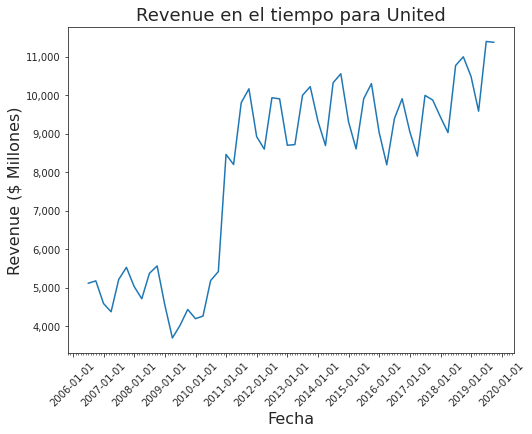

In [ ]:
def plot_time_series(dates, values, title, x_label, y_label):
    """
    dates: debe ser una serie de tiempo en el eje x
    values: los valores de y
    title: titulo string
    x_label: label en x
    y_label: label en y
    """

    years_locator = mdates.YearLocator()
    months_locator = mdates.MonthLocator()
    years_format = mdates.DateFormatter('%Y-%m-%d') # Probar %Y

    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)

    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.xaxis.set_major_locator(years_locator)
    ax.xaxis.set_major_formatter(years_format)
    ax.xaxis.set_minor_locator(months_locator)

    sns.lineplot(x=dates, y=values, ci=None)

    rotation = 45
    plt.setp(ax.get_xticklabels(), rotation=rotation)
    plt.xlabel(x_label, fontsize='16')
    plt.ylabel(y_label, fontsize='16')
    plt.title(title, fontsize='18')

    plt.show()
    
united_revenues['DATE'] = united_revenues.apply(lambda r: datetime(int(r['YEAR']), int(r['MONTH']), int(r['DAY'])), axis=1)
plot_time_series(united_revenues['DATE'], united_revenues['REVENUE'], 'Revenue en el tiempo para United', 'Fecha', 'Revenue ($ Millones)')

### Pregunta:

¿Observa algún patrón interesante en estos datos?

**Respuesta.** Algo que notamos es el comportamiento cíclico estacional, la disminución de la demanda en enero y un pico en 2011 causado por la fusión de dos aerolíneas.

### Desafio 1

Repetir el analisis anterios```airline_fuel_cost.csv```. Observaras mas variables; por el bien del ejercicio, solo nos interesa **QUARTER** y **TOTAL_COST**.

In [ ]:
airline_costs = pd.read_csv('airline_fuel_costs.csv')
airline_costs

YEAR  QUARTER  MONTH  ...   TDOMT_COST   TINT_COST   TOTAL_COST
0     2010        1      1  ...   10794066.0     62257.0   10856323.0
1     2010        1      1  ...     754533.0         0.0     754533.0
2     2010        1      1  ...   62149000.0  55870000.0  118019000.0
3     2010        1      1  ...    4514818.0  39381611.0   43896429.0
4     2010        1      1  ...    5659367.0   3377904.0    9037271.0
...    ...      ...    ...  ...          ...         ...          ...
6588  2019        2      5  ...  371853619.0   6309955.0  378163574.0
6589  2019        2      6  ...  351593930.0   6375770.0  357969700.0
6590  2019        3      7  ...  362654100.0   5797137.0  368451237.0
6591  2019        3      8  ...  342904670.0   3911530.0  346816200.0
6592  2019        3      9  ...  317265738.0   2343476.0  319609214.0

[6593 rows x 48 columns]

In [ ]:
#Solo United
united_costs = airline_costs[airline_costs['UNIQUE_CARRIER'] == 'UA']

# Mantener columnas de interes
columns_to_keep = ['YEAR', 'QUARTER', 'MONTH', 'TOTAL_COST']
united_costs = united_costs[columns_to_keep]
united_costs

YEAR  QUARTER  MONTH   TOTAL_COST
47    2010        1      1  320169235.0
106   2010        1      2  278634843.0
165   2010        1      3  339915313.0
224   2010        2      4  348193934.0
283   2010        2      5  385441906.0
...    ...      ...    ...          ...
6380  2019        2      5  653718728.0
6430  2019        2      6  628169636.0
6480  2019        3      7  645067356.0
6529  2019        3      8  626433174.0
6577  2019        3      9  561519578.0

[117 rows x 4 columns]

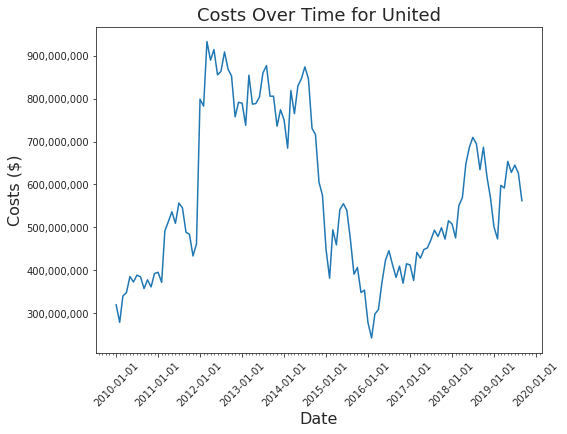

In [ ]:
united_costs['DATE'] = united_costs.apply(lambda r: datetime(int(r['YEAR']), int(r['MONTH']), 1), axis=1)
plot_time_series(united_costs['DATE'], united_costs['TOTAL_COST'], 'Costs Over Time for United', 'Date', 'Costs ($)')

Para completar el análisis, ahora veremos el precio de los productos petrolíferos a través del archivo ```oil.csv```:

In [ ]:
oil_prices = pd.read_csv('oil.csv')
oil_prices['DATE'] = pd.to_datetime(oil_prices['DATE'])
oil_prices

DATE  NY_GASOLINE_PRICE  ...  MONTH  KEROSENE_PRICE
0   1990-04-01              0.600  ...      4           0.540
1   1990-05-01              0.643  ...      5           0.515
2   1990-06-01              0.646  ...      6           0.494
3   1990-07-01              0.653  ...      7           0.535
4   1990-08-01              0.897  ...      8           0.791
..         ...                ...  ...    ...             ...
352 2019-08-01              1.694  ...      8           1.800
353 2019-09-01              1.726  ...      9           1.874
354 2019-10-01              1.728  ...     10           1.861
355 2019-11-01              1.724  ...     11           1.824
356 2019-12-01              1.713  ...     12           1.893

[357 rows x 6 columns]

A partir de esto, podemos ver que tenemos los precios de 3 productos petrolíferos diferentes al comienzo de cada mes. Dibujémoslos para ver la diferencia.

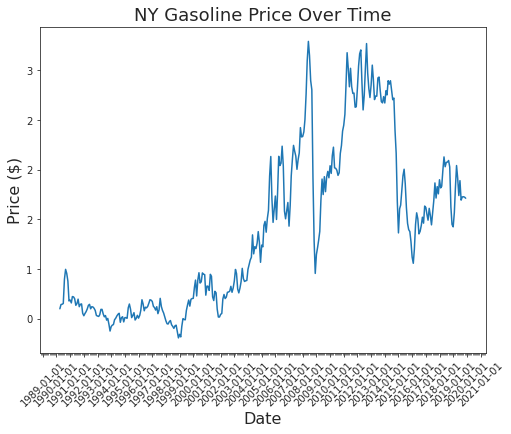

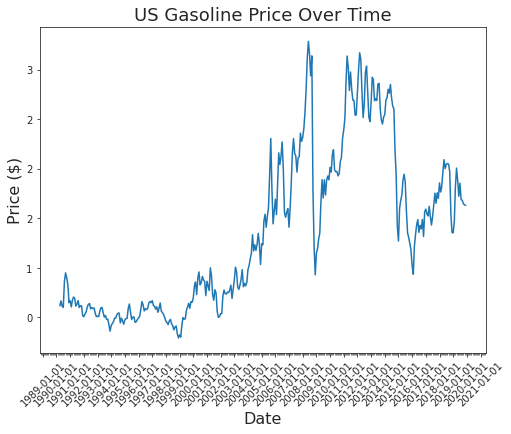

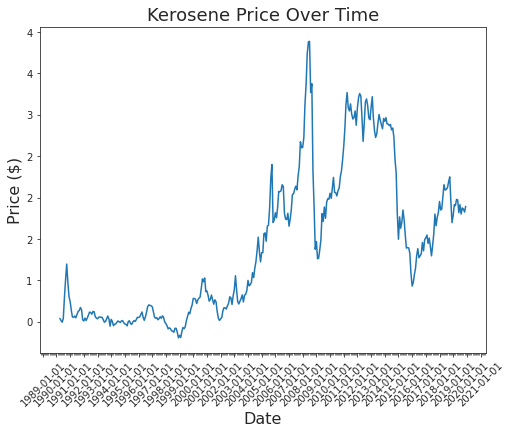

In [ ]:
plot_time_series(oil_prices['DATE'], oil_prices['NY_GASOLINE_PRICE'], 'NY Gasoline Price Over Time', 'Date', 'Price ($)')
plot_time_series(oil_prices['DATE'], oil_prices['US_GASOLINE_PRICE'], 'US Gasoline Price Over Time', 'Date', 'Price ($)')
plot_time_series(oil_prices['DATE'], oil_prices['KEROSENE_PRICE'], 'Kerosene Price Over Time', 'Date', 'Price ($)')

A partir de esto, podemos ver que todos ellos están altamente correlacionados con variaciones menores. Para nuestro deleite, también está muy relacionado con los costos de las aerolíneas generados anteriormente. A los efectos de este estudio, debería bastar con elegir uno de ellos.

### Pregunta:

¿Cuál deberías elegir?

**Respuesta.** El queroseno es lo que utilizan los aviones para volar y, por lo tanto, debería ser el centro de atención. Siempre es importante elegir variables que tengan relaciones causales lo más claras posible con lo que estamos prediciendo. Este tipo de uso del conocimiento del dominio es crucial para evitar la minería de datos en busca de correlaciones en lugar de causas.

In [ ]:
columns_to_keep = ['YEAR', 'MONTH', 'DATE', 'KEROSENE_PRICE']
oil_prices = oil_prices[columns_to_keep]
oil_prices

YEAR  MONTH       DATE  KEROSENE_PRICE
0    1990      4 1990-04-01           0.540
1    1990      5 1990-05-01           0.515
2    1990      6 1990-06-01           0.494
3    1990      7 1990-07-01           0.535
4    1990      8 1990-08-01           0.791
..    ...    ...        ...             ...
352  2019      8 2019-08-01           1.800
353  2019      9 2019-09-01           1.874
354  2019     10 2019-10-01           1.861
355  2019     11 2019-11-01           1.824
356  2019     12 2019-12-01           1.893

[357 rows x 4 columns]


En general, pero especialmente en el caso de series de tiempo, es importante recordar estos procedimientos de recopilación de datos. En este caso, tenemos 3 series de tiempo: ingresos, costos y precios del petróleo. Como sabemos que la ganancia es simplemente una función de los costos, sería tentador deshacerse de los precios del petróleo. ¿Por qué nos importa el precio de un insumo en el costo cuando tenemos el costo real? La respuesta radica en el retraso entre el momento en que se recopilan los datos y lo que realmente está sucediendo en un momento dado. Para este caso:

1. **Ingresos de la aerolínea:** Los ingresos trimestrales presentados por la aerolínea a la SEC.
2. **Costos de la aerolínea:** La adquisición de estos datos lleva tiempo y su empresa demora 3 meses en calcular los costos. Así, si estamos en diciembre, tienes todos los gastos hasta septiembre de ese año.
3. **Precios del petróleo:** Este es un precio en diamico que cotiza públicamente. En cualquier momento dado, conocemos exactamente el precio del queroseno

### Desafio 2

¿Cómo encajan estas piezas con respecto a nuestro objetivo y qué información nos falta?

**Respuesta.** Nuestro objetivo es predecir los ingresos. Sin embargo, todo lo que tenemos es información sobre los costos del pasado. Esto puede parecernos inútil, pero los costos son casi lo mismo que los ingresos. Si hacemos una gran suposición (**recuerde sus suposiciones**) de que los ingresos/pasajero y el costo/pasajero son aproximadamente constantes en el corto plazo, entonces el costo es un buen predictor de ingresos. Entonces, nuestro modelo inicial, dados nuestros datos existentes, se parece a:

$$\text{Revenue} = f( \text{Past Costs} )$$

Pero esto no tiene en cuenta nada en el presente. Además, sabemos que los ingresos están directamente relacionados con la cantidad de personas que vuelan en la aerolínea. Dada nuestra suposición, si pudiéramos incorporar el número de pasajeros, entonces este sería un muy buen modelo:

$$\text{Revenue} = f( \text{Past Costs}, \text{Number of passenger} )$$

Esto nos guía para complementar nuestros datos actuales tratando de encontrar una buena medida del número actual de pasajeros en una aerolínea.

## Complementando con los datos BTS 

Ahora que sabemos que queremos obtener una predicción del número probable de pasajeros en una aerolínea, sería bueno encontrar un conjunto de datos del número histórico de pasajeros de las aerolíneas. Después de buscar en Internet, encontramos la fuente de datos perfecta de la [Oficina de Estadísticas de Transporte](https://www.transtats.bts.gov/Tables.asp?DB_ID=111&DB_Name=Air%20Carrier%20Statistics%20%28Form% 2041% 20Traffic% 29-% 20All% 20Carriers & DB_Short_Name = Air% 20Carriers). A saber, el conjunto de datos del mercado nacional T-100 (operadores de EE. UU.) Contiene los siguientes atributos:


1. **PASSENGERS:** El numero de pasajeros en el segmento 
2. **UNIQUE_CARRIER:** el codigo del carrier
3. **ORIGIN_AIRPORT_ID:**  ID del aeropuerto del origen
4. **DEST_AIRPORT_ID:** areopuerto de destino
5. **YEAR:** Año
6. **MONTH:** Ms
7. **QUARTER:** cuarto del año

La forma en que se organizan los datos es que agrega el número de pasajeros mensuales agrupados por aerolínea, así como por aeropuertos de origen y destino. Es decir, cada fila representa a todos los pasajeros que volaron entre dos ciudades durante un mes y una aerolínea determinados. Al observar los datos que ya tiene, decide que solo utilizará la información desde 2012, ya que este es el primer año de funcionamiento que United hizo en la forma que conocemos hoy. Los datos brutos están disponibles en ```airline_passengers.csv```. Investiguemos cómo se ve este conjunto de datos:

In [ ]:
airline_passengers = pd.read_csv('airline_passengers.csv')
airline_passengers

PASSENGERS UNIQUE_CARRIER  ... QUARTER  MONTH
0               0.0             GV  ...       1      2
1               0.0             KO  ...       1      2
2               0.0             KO  ...       1      2
3               0.0             KO  ...       1      2
4               0.0             KO  ...       1      2
...             ...            ...  ...     ...    ...
2022105     96984.0             AS  ...       3      7
2022106     97011.0             AS  ...       2      6
2022107     97098.0             AS  ...       3      8
2022108     97329.0             DL  ...       1      3
2022109     97644.0             AS  ...       3      7

[2022110 rows x 8 columns]

### Visualizando los datos

Ahora visualicemos estos datos. Realmente sería bueno visualizar todo en un mapa para confirmar que los datos son precisos. El DataFrame que se muestra arriba sería una pesadilla para probar y analizar sin más transformación.

Lo primero que notamos es que hay muchos datos aquí y sería bueno saber a qué aeropuertos corresponden esos ID. Como solo estamos interesados en United, eso debería manejar muchas de las filas. Para los aeropuertos, también encontró [esto](https://www.transtats.bts.gov/FieldInfo.asp?Field_Desc=An%20identification%20number%20assigned%20by%20US%20DOT%20to%20identify%20a%20unique%20airline%20%28carrier%29.%20A%20unique%20airline%20%28carrier%29%20is%20defined%20as%20one%20holding%20and%20reporting%20under%20the%20same%20DOT%20certificate%20regardless%20of%20its%20Code%2C%20Name%2C%20or%20holding%20company/corporation.&Field_Type=Num&Lookup_Table=L_AIRLINE_ID&Table_ID=292&SYS_Table_Name=T_T100_MARKET_ALL_CARRIER&Sys_Field_Name=AIRLINE_ID) en la documentación del sitio web de BTS, que nos ayudará a determinar qué aeropuertos son cuáles. Además, también da la ```LAT``` y ```LON``` (latitud y longitud) para cada aeropuerto que nos ayudará con visualizaciones de mapas:

In [ ]:
united_passengers = airline_passengers[airline_passengers['UNIQUE_CARRIER'] == 'UA']
united_passengers

PASSENGERS UNIQUE_CARRIER    UNIQUE_CARRIER_NAME  ...  YEAR  QUARTER  MONTH
10070           0.0             UA  United Air Lines Inc.  ...  2012        1      1
10071           0.0             UA  United Air Lines Inc.  ...  2012        1      1
10072           0.0             UA  United Air Lines Inc.  ...  2012        1      1
10073           0.0             UA  United Air Lines Inc.  ...  2012        1      1
10074           0.0             UA  United Air Lines Inc.  ...  2012        1      1
...             ...            ...                    ...  ...   ...      ...    ...
2022079     84216.0             UA  United Air Lines Inc.  ...  2019        2      5
2022080     85494.0             UA  United Air Lines Inc.  ...  2019        2      6
2022083     87077.0             UA  United Air Lines Inc.  ...  2019        3      7
2022096     92284.0             UA  United Air Lines Inc.  ...  2019        3      8
2022100     93725.0             UA  United Air Lines Inc.  ...  2019        3      8

[120387 rows x 8 columns]

In [ ]:
airports = pd.read_csv('airports.csv')
airports

Code  ...         LON
0     10001  ...         NaN
1     10003  ...         NaN
2     10004  ...         NaN
3     10005  ...  -98.586185
4     10006  ...         NaN
...     ...  ...         ...
6531  16871  ...  -72.505674
6532  16872  ...         NaN
6533  16873  ...         NaN
6534  16874  ...  116.412341
6535  99999  ...         NaN

[6536 rows x 4 columns]

Como podemos ver, hay muchos aeropuertos diferentes y muchos de ellos son bastante pequeños con ubicaciones desconocidas (por ejemplo, "Punto desconocido en Alaska"). También vemos que algunos aeropuertos tienen una lista de ```NaN``` para su ubicación. Intentemos filtrar los aeropuertos a los que United no vuela y esperemos que todas las filas restantes tengan sus ubicaciones en la lista. Primero, necesitamos los aeropuertos únicos:

In [ ]:
unique_airports = set(list(united_passengers['ORIGIN_AIRPORT_ID'].unique()))
unique_airports.update(list(united_passengers['DEST_AIRPORT_ID'].unique()))
len(unique_airports)

243

Ahora, limitemos el DataFrame de los aeropuertos a aquellos a los que vuela United y veamos si alguno de ellos es nulo:

In [ ]:
united_airports = airports[airports['Code'].isin(list(unique_airports))]
united_airports[united_airports['LAT'].isnull()]

Code                                        Description  LAT  LON
531   10558  Scottsbluff, NE: Western Neb. Regional/William...  NaN  NaN
685   10713                      Boise, ID: Boise Air Terminal  NaN  NaN
958   10994       Charleston, SC: Charleston AFB/International  NaN  NaN
1189  11233  Cheyenne, WY: Cheyenne Regional/Jerry Olson Field  NaN  NaN
1375  11433            Detroit, MI: Detroit Metro Wayne County  NaN  NaN
1658  11726                        Topeka, KS: Topeka Regional  NaN  NaN
2130  12217  Huntsville, AL: Huntsville International-Carl ...  NaN  NaN
2136  12223    Ashland, WV: Tri-State/Milton J. Ferguson Field  NaN  NaN
2177  12266  Houston, TX: George Bush Intercontinental/Houston  NaN  NaN
2353  12448  Jackson/Vicksburg, MS: Jackson Medgar Wiley Ev...  NaN  NaN
2639  12758  Kona, HI: Ellison Onizuka Kona International a...  NaN  NaN
2822  12951  Lafayette, LA: Lafayette Regional Paul Fournet...  NaN  NaN
2863  12992  Little Rock, AR: Bill and Hillary Clinton Nat ...  NaN  NaN
3100  13234               Midway Island, TT: Sand Island Field  NaN  NaN
3605  13756                   Port Hueneme, CA: Point Mugu NAS  NaN  NaN
3655  13809    Ocala, FL: Ocala International-Jim Taylor Field  NaN  NaN
3889  14054  Pendleton, OR: Eastern Oregon Regional at Pend...  NaN  NaN
3946  14112  St. Petersburg, FL: St Pete Clearwater Interna...  NaN  NaN
4138  14307       Providence, RI: Theodore Francis Green State  NaN  NaN
4357  14574  Roanoke, VA: Roanoke Blacksburg Regional Woodr...  NaN  NaN
4365  14582  Rota, TT: Benjamin Taisacan Manglona Internati...  NaN  NaN
4509  14730  Louisville, KY: Louisville Muhammad Ali Intern...  NaN  NaN
5150  15389  Twin Falls, ID: Joslin Field - Magic Valley Re...  NaN  NaN
5793  16101   Yakima, WA: Yakima Air Terminal/McAllister Field  NaN  NaN

Desafortunadamente, muchos de ellos son nulos y algunos de ellos son grandes aeropuertos (George Bush Intercontinental en Houston es un gran centro). qué hacemos?

Resulta que podemos usar el paquete [GeoPy](https://geopy.readthedocs.io/en/stable/) paquete para tomar ubicaciones dadas direcciones. (En general, esta es una buena práctica; cuando tenga un problema con sus datos, sea ingenioso para conectarse a Internet y buscar algo que pueda ayudar a resolver su problema. No reinvente la rueda ni asuma, por el contrario, que no hay nada tu puedes hacer.)

La parte mala es que las direcciones en el DataFrame no están realmente estandarizadas. Sería realmente bueno si tuviéramos el código internacional IATA de 3 letras para cada aeropuerto. Afortunadamente para nosotros, BTS lo proporciona [esto](https://www.bts.gov/topics/airlines-and-airports/world-airport-codes). Convirtamos esta tabla HTML en un DataFrame ```pandas```:

In [ ]:
airport_codes = pd.read_html('https://www.bts.gov/topics/airlines-and-airports/world-airport-codes')[0]
airport_codes

Code                                  City: Airport
0     01A         Afognak Lake, AK: Afognak Lake Airport
1     03A  Granite Mountain, AK: Bear Creek Mining Strip
2     04A                       Lik, AK: Lik Mining Camp
3     05A         Little Squaw, AK: Little Squaw Airport
4     06A                     Kizhuyak, AK: Kizhuyak Bay
...   ...                                            ...
6505  ZXZ             Waterville, WA: Waterville Airport
6506  ZYL                Sylhet, Bangladesh: Savannakhet
6507  ZZU                   Mzuzu, Malawi: Mzuzu Airport
6508  ZZV           Zanesville, OH: Zanesville Municipal
6509  ZZZ                        Unknown Point in Alaska

[6510 rows x 2 columns]

Ahora podemos fusionar esto fácilmente y encontrar las ubicaciones usando ```GeoPy``` de la siguiente manera:

In [ ]:
geolocator = Nominatim(user_agent="Airport Lat/Long Finder", timeout=100)
geolocator.geocode('IAH airport TX')

Location(George Bush Intercontinental Airport - Houston, 2800, North Terminal Road, Houston, Harris County, Texas, 77066, United States, (29.9841416, -95.33298595614491, 0.0))

### Desafio 3

Hagamos el merge de ```united_airports``` DataFrame with the IATA codes DataFrame. Then using ```GeoPy```, escriba una función para asignar las latitudes y longitudes que faltan de los aeropuertos a los que vuela United.

In [ ]:
united_airports = united_airports.merge(airport_codes, left_on='Description', right_on='City: Airport', suffixes=('_BTS', '_IATA'))
united_airports

Code_BTS  ...                                      City: Airport
0       10135  ...  Allentown/Bethlehem/Easton, PA: Lehigh Valley ...
1       10136  ...                      Abilene, TX: Abilene Regional
2       10140  ...  Albuquerque, NM: Albuquerque International Sun...
3       10155  ...                            Waco, TX: Waco Regional
4       10158  ...     Atlantic City, NJ: Atlantic City International
..        ...  ...                                                ...
238     15422  ...                             Guam, TT: Andersen AFB
239     15919  ...      Fayetteville, AR: Northwest Arkansas Regional
240     16091  ...                            Detroit, MI: Willow Run
241     16101  ...   Yakima, WA: Yakima Air Terminal/McAllister Field
242     16133  ...  Youngstown/Warren, OH: Youngstown-Warren Regional

[243 rows x 6 columns]

In [ ]:
def get_airport_lat_long_by_iata_code(code, state):

    geolocator = Nominatim(user_agent="Airport Lat/Long Finder", timeout=100)
    code += ' airport '
    code += state
        
    try:    
        lat_long = geolocator.geocode(code)
        if lat_long:
            
            return str(lat_long.latitude), str(lat_long.longitude)
        else:
            return None, None
    except:
            print('Error reading ' + name)
            return None, None
        
    # necesario para evitar errores de rastreo
    time.sleep(1)
        
lat_lons = united_airports[united_airports['LAT'].isnull()].apply(lambda r: get_airport_lat_long_by_iata_code(r['Code_IATA'], r['Description'].split(':')[0].split(',')[-1]), axis=1)

In [ ]:
for i in lat_lons.index:
    united_airports['LAT'].loc[i] = lat_lons.loc[i][0]
    united_airports['LON'].loc[i] = lat_lons.loc[i][1]

In [ ]:
united_airports

Code_BTS  ...                                      City: Airport
0       10135  ...  Allentown/Bethlehem/Easton, PA: Lehigh Valley ...
1       10136  ...                      Abilene, TX: Abilene Regional
2       10140  ...  Albuquerque, NM: Albuquerque International Sun...
3       10155  ...                            Waco, TX: Waco Regional
4       10158  ...     Atlantic City, NJ: Atlantic City International
..        ...  ...                                                ...
238     15422  ...                             Guam, TT: Andersen AFB
239     15919  ...      Fayetteville, AR: Northwest Arkansas Regional
240     16091  ...                            Detroit, MI: Willow Run
241     16101  ...   Yakima, WA: Yakima Air Terminal/McAllister Field
242     16133  ...  Youngstown/Warren, OH: Youngstown-Warren Regional

[243 rows x 6 columns]

### Hacer el plot en un mapa 

Usemos [Plotly](https://plotly.com/) Para visuzalizar la data. Primero ```LAT``` y ```LON``` para cada ```ORIGIN``` ay ```DEST``` de aeropuerto:

In [ ]:
united_paths = united_passengers.groupby(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'UNIQUE_CARRIER', 'YEAR', 'MONTH'])['PASSENGERS'].sum().reset_index()
united_paths = united_paths.merge(airports, left_on='ORIGIN_AIRPORT_ID', right_on='Code')
united_paths = united_paths.merge(airports, left_on='DEST_AIRPORT_ID', right_on='Code', suffixes=("_ORIGIN", "_DEST"))
united_paths

ORIGIN_AIRPORT_ID  DEST_AIRPORT_ID  ...   LAT_DEST   LON_DEST
0                   10135            10821  ...  39.174526 -76.671048
1                   10140            10821  ...  39.174526 -76.671048
2                   10140            10821  ...  39.174526 -76.671048
3                   10140            10821  ...  39.174526 -76.671048
4                   10257            10821  ...  39.174526 -76.671048
...                   ...              ...  ...        ...        ...
116382              14771            10728  ...  29.952375 -94.021781
116383              14771            10728  ...  29.952375 -94.021781
116384              14771            13203  ...  32.693840 -83.648018
116385              15074            13184  ...  43.535796 -84.082850
116386              15304            16133  ...  41.260737 -80.674979

[116387 rows x 14 columns]

In [ ]:
def plot_flight_paths(paths, airports):
    fig = go.Figure()

    tmp = paths.groupby(['LAT_ORIGIN', 'LON_ORIGIN', 'LAT_DEST', 'LON_DEST']).sum().reset_index()
    max_passengers = float(tmp['PASSENGERS'].max())

    for index, path in tmp.iterrows():
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'USA-states',
                lon = [path['LON_ORIGIN'], path['LON_DEST']],
                lat = [path['LAT_ORIGIN'], path['LAT_DEST']],
                mode = 'lines',
                hoverinfo = "none",
                line = dict(width = 2, color = 'rgb(0, 93, 170)'),
                opacity = path['PASSENGERS'] / max_passengers,
            )
        )

    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = airports['LON'],
        lat = airports['LAT'],
        hoverinfo = 'text',
        text = airports['Description'],
        mode = 'markers',
        marker = dict(
            size = 2,
            color = 'rgb(255, 0, 0)',
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
            )
        )))

    fig.update_layout(
        title_text = 'Vuelos por United',
        font = {'size':36},
        showlegend = False,
        geo = go.layout.Geo(
            scope = 'north america',
            projection_type = 'kavrayskiy7',
            showland = True,
            showlakes = True,
            showcountries = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
    fig.show()
    
plot_flight_paths(united_paths[united_paths['YEAR'] == 2012], united_airports)

¿Qué está haciendo Hawái en la ubicación de Hong Kong? En este caso, si lee la documentación en el sitio web de BTS, reafirmaría que es simplemente una latitud y longitud incorrectas. Cambiemos los de los vuelos LIH:

In [ ]:
def replace_lat_lon(r, lat_or_lon, origin_or_dest):
    """
    lat_or_lon: LAT o LON
    origin_or_dest: ORIGIN o DEST
    """
    
    LIH_code = 12982
    LIH_lat, LIH_lon = 21.976111, -159.338889
    
    copy_column = lat_or_lon + '_'
    copy_column += origin_or_dest
    
    code_column = 'Code_' + origin_or_dest
    
    if r[code_column] == LIH_code:
        return LIH_lat if lat_or_lon == 'LAT' else LIH_lon
    else:
        return r[copy_column]
    

united_paths['LAT_ORIGIN'] = united_paths.apply(lambda r: replace_lat_lon(r, 'LAT', "ORIGIN"), axis=1)
united_paths['LON_ORIGIN'] = united_paths.apply(lambda r: replace_lat_lon(r, 'LON', "ORIGIN"), axis=1)
united_paths['LAT_DEST'] = united_paths.apply(lambda r: replace_lat_lon(r, 'LAT', "DEST"), axis=1)
united_paths['LON_DEST'] = united_paths.apply(lambda r: replace_lat_lon(r, 'LON', "DEST"), axis=1)

### Desafio 4

Modifique la función de trazado anterior para tomar el año y comparar los vuelos de United de 2012, 2015 y 2019. ¿Cuáles son algunas de las tendencias que observa?

**Respuesta.** Como se esperaba, vemos un aumento general en el número de pasajeros a lo largo del tiempo. Una cosa interesante que notamos es el grupo de vuelos en el Pacífico Sur. Esto se debe al monopolio que tiene United de volar a Guam. También podemos ver que se eliminan y agregan rutas de vuelo individuales (por ejemplo, la de Puerto Rico). Sin embargo, la principal tendencia general es el aumento de vuelos al sur, como en Texas y Florida. Esto tiene sentido porque el corredor NYC-LA ha estado bastante ocupado durante mucho tiempo con poco espacio para el crecimiento:

In [ ]:
def plot_flight_paths(paths, airports, year):
    fig = go.Figure()
    
    tmp = paths.groupby(['LAT_ORIGIN', 'LON_ORIGIN', 'LAT_DEST', 'LON_DEST', 'YEAR']).sum().reset_index()
    
    max_passengers = float(tmp['PASSENGERS'].max())
    tmp = tmp[tmp['YEAR'] == year]

    for index, path in tmp.iterrows():
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'USA-states',
                lon = [path['LON_ORIGIN'], path['LON_DEST']],
                lat = [path['LAT_ORIGIN'], path['LAT_DEST']],
                mode = 'lines',
                hoverinfo = "none",
                line = dict(width = 2, color = 'rgb(0, 93, 170)'),
                opacity = path['PASSENGERS']**1.5 / max_passengers**1.5,
            )
        )


    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = airports['LON'],
        lat = airports['LAT'],
        hoverinfo = 'text',
        text = airports['Description'],
        mode = 'markers',
        marker = dict(
            size = 2,
            color = 'rgb(255, 0, 0)',
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
            )
        )))

    fig.update_layout(
        title_text = 'Vuelos a United',
        font = {'size':36},
        showlegend = False,
        geo = go.layout.Geo(
            scope = 'north america',
            projection_type = 'kavrayskiy7',
            showland = True,
            showlakes = True,
            showcountries = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
    fig.show()

In [ ]:
plot_flight_paths(united_paths, united_airports, 2012)

In [ ]:
plot_flight_paths(united_paths, united_airports, 2015)

In [ ]:
plot_flight_paths(united_paths, united_airports, 2019)

### Pasajeros e ingresos

Esto completa nuestra EDA básica sobre los datos de BTS. El punto que debe enfatizarse es que esta EDA se utilizó únicamente como un medio para validar los datos. Todavía no podemos extraer hipótesis sobre los ingresos a partir de los datos de los pasajeros. Recuerde que no tenemos esta información hasta 3 meses después del hecho. Sin embargo, si lo hiciéramos, deberíamos asegurarnos de que esta sea información útil.

Cuando se trata de series de tiempo, es importante lidiar con las tendencias. Si dos series están predominantemente dominadas por una tendencia, sus fluctuaciones individuales se pierden y esto puede llevar a una conclusión falsa. Considere el siguiente ejemplo de dos líneas aleatorias:

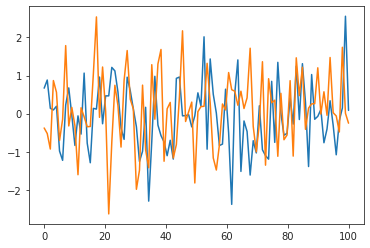

In [ ]:
def plot_series_with_slope(m):
    n = 100
    t = np.linspace(0, n, n)

    X_1 = m*t + np.random.normal(size=n)
    X_2 = m*t + np.random.normal(size=n)

    sns.lineplot(t, X_1)
    sns.lineplot(t, X_2)

def get_corr_with_slope(m):
    n = 100
    t = np.linspace(0, 10*n, n)

    X_1 = m*t + np.random.normal(size=n)
    X_2 = m*t + np.random.normal(size=n)
    
    return np.corrcoef(X_1, X_2)

plot_series_with_slope(0)

A simple vista, estas series parecen increíblemente ajenas. Medir su correlación confirma esto:

In [ ]:
get_corr_with_slope(0)

array([[1.        , 0.04682793],
       [0.04682793, 1.        ]])

Sin embargo, ¿qué pasa si aumentamos la pendiente entre ellos ?:

array([[1.        , 0.99898365],
       [0.99898365, 1.        ]])

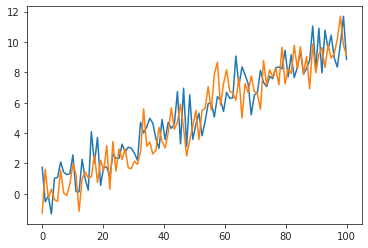

In [ ]:
plot_series_with_slope(0.1)
get_corr_with_slope(0.1)

Es importante eliminar la tendencia de esta línea. Esto se hace fácilmente correlacionando la diferencia entre puntos:

In [ ]:
m = 1
n = 1000
t = np.linspace(0, 10*n, n)

X_1 = pd.Series(m*t + np.random.normal(size=n))
X_2 = pd.Series(m*t + np.random.normal(size=n))

def time_series_corr(X_1, X_2):
    
    diff_1 = X_1[1:]-X_1.shift()[1:]
    diff_2 = X_2[1:]-X_2.shift()[1:]
    
    return np.corrcoef(diff_1, diff_2)

time_series_corr(X_1, X_2)

array([[1.        , 0.01002729],
       [0.01002729, 1.        ]])

Ahora que podemos correlacionar dos series de tiempo, veamos cómo se correlacionan los pasajeros y los ingresos. Lo primero que necesitamos es fusionar los DataFrames de ingresos y pasajeros. Tal como está, nuestro DataFrame de pasajeros tiene una fila para cada aeropuerto de origen y destino, para cada mes. Entonces, necesitamos sumar estos números para cada mes. Sin embargo, los ingresos solo salen cada trimestre, por lo que también agregaremos el trimestre al DataFrame de pasajeros:

In [ ]:
united_passengers_by_month = united_passengers.groupby(['YEAR', 'MONTH']).sum()['PASSENGERS'].reset_index()
united_passengers_by_month['DATE'] = united_passengers_by_month.apply(lambda r: datetime(int(r['YEAR']), int(r['MONTH']), 1), axis=1)
united_passengers_by_month['AVG']=united_passengers_by_month['PASSENGERS']/30
united_passengers_by_month

YEAR  MONTH  PASSENGERS       DATE            AVG
0   2012      1   4988564.0 2012-01-01  166285.466667
1   2012      2   4921042.0 2012-02-01  164034.733333
2   2012      3   5952399.0 2012-03-01  198413.300000
3   2012      4   5761602.0 2012-04-01  192053.400000
4   2012      5   5912575.0 2012-05-01  197085.833333
..   ...    ...         ...        ...            ...
91  2019      8   8002440.0 2019-08-01  266748.000000
92  2019      9   6867783.0 2019-09-01  228926.100000
93  2019     10   7562636.0 2019-10-01  252087.866667
94  2019     11   6800650.0 2019-11-01  226688.333333
95  2019     12   7380276.0 2019-12-01  246009.200000

[96 rows x 5 columns]

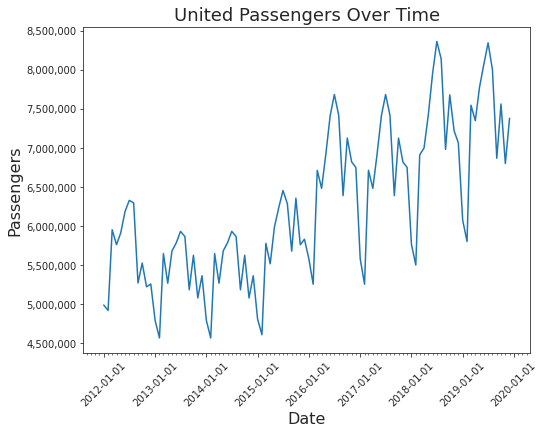

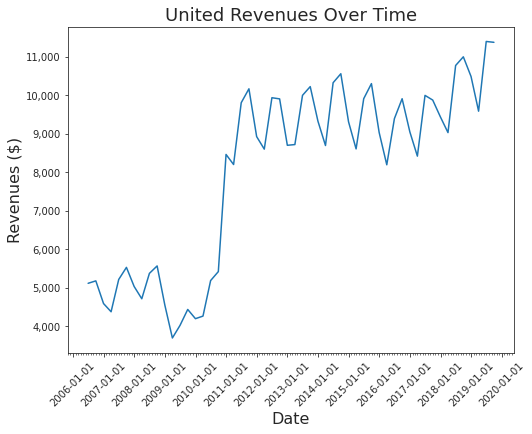

In [ ]:
plot_time_series(united_passengers_by_month['DATE'], united_passengers_by_month['PASSENGERS'], 'United Passengers Over Time', 'Date', 'Passengers')
plot_time_series(united_revenues['DATE'], united_revenues['REVENUE'], 'United Revenues Over Time', 'Date', 'Revenues ($)')

Antes de que podamos correlacionar estas series, debemos unirnos en el trimestre para que los DataFrames coincidan en granularidad:

In [ ]:
united_passengers_by_quarter = united_passengers.groupby(['YEAR', 'QUARTER']).sum()['PASSENGERS'].reset_index()
united_passengers_by_quarter

YEAR  QUARTER  PASSENGERS
0   2012        1  15862005.0
1   2012        2  17862792.0
2   2012        3  17896866.0
3   2012        4  16007030.0
4   2013        1  15006472.0
5   2013        2  16736598.0
6   2013        3  16982539.0
7   2013        4  16070735.0
8   2014        1  15006472.0
9   2014        2  16736598.0
10  2014        3  16982539.0
11  2014        4  16070735.0
12  2015        1  15197245.0
13  2015        2  17742901.0
14  2015        3  18421501.0
15  2015        4  17948413.0
16  2016        1  17551277.0
17  2016        2  20814077.0
18  2016        3  21490531.0
19  2016        4  20698402.0
20  2017        1  17551277.0
21  2017        2  20814077.0
22  2017        3  21490531.0
23  2017        4  20698402.0
24  2018        1  18179655.0
25  2018        2  22379792.0
26  2018        3  23482892.0
27  2018        4  21964678.0
28  2019        1  19426505.0
29  2019        2  23200245.0
30  2019        3  23215698.0
31  2019        4  21743562.0

In [ ]:
united_revenues['QUARTER'] = united_revenues.apply(lambda r: int(r['MONTH']//3), axis=1)
merged_df = pd.merge(united_revenues, united_passengers_by_quarter, on=['YEAR', 'QUARTER'])
time_series_corr(merged_df['REVENUE'], merged_df['PASSENGERS'])

array([[1.        , 0.88444987],
       [0.88444987, 1.        ]])

A partir de esto, podemos ver que los pasajeros están extremadamente correlacionados con los ingresos. Por lo tanto, conocer el número de pasajeros proporciona una señal de alta calidad para predecir los ingresos. Sin embargo, todavía tenemos el problema de la información rezagada. ¿Puedes pensar en algunas fuentes de datos que puedan darnos información hasta el momento?

## Twitter Data

Para lidiar con el problema del retraso, intentaremos predecir la cantidad actual de pasajeros que usan Twitter. Específicamente, planteamos la hipótesis de que la cantidad de tweets en un mes determinado está correlacionada con los pasajeros de ese mes. El Twitter de United se puede encontrar en el ```united_tweets.csv``` y tiene las siguientes características simples:

1. **COUNT:** La cantidad de tweets en Twitter que United había etiquetado en ellos.
2. **DATE:** La fecha de los tweets

In [ ]:
united_tweets = pd.read_csv('united_tweets.csv')
united_tweets

COUNT        DATE
0       153  2012-01-01
1       209  2012-01-02
2       223  2012-01-03
3       225  2012-01-04
4       168  2012-01-05
...     ...         ...
2917   1931  2019-12-27
2918   1374  2019-12-28
2919   1441  2019-12-29
2920   1622  2019-12-30
2921   1712  2019-12-31

[2922 rows x 2 columns]

Ahora verificamos si estos tweets están correlacionados con los pasajeros agregando los tweets por mes:

In [ ]:
united_tweets['DATE'] = pd.to_datetime(united_tweets['DATE'])
united_tweets['YEAR'] = united_tweets['DATE'].dt.year
united_tweets['MONTH'] = united_tweets['DATE'].dt.month
united_tweets_by_month = united_tweets.groupby(['YEAR', 'MONTH']).sum().reset_index()
united_tweets_by_month

YEAR  MONTH  COUNT
0   2012      1   8371
1   2012      2   6663
2   2012      3  15159
3   2012      4   9774
4   2012      5  35640
..   ...    ...    ...
91  2019      8  52118
92  2019      9  81786
93  2019     10  67936
94  2019     11  43382
95  2019     12  54799

[96 rows x 3 columns]

In [ ]:
time_series_corr(united_tweets_by_month['COUNT'], united_passengers_by_month['PASSENGERS'])

array([[ 1.        , -0.04386521],
       [-0.04386521,  1.        ]])

Desafortunadamente, este es un resultado increíblemente decepcionante. Veamos si podemos averiguar qué está pasando:

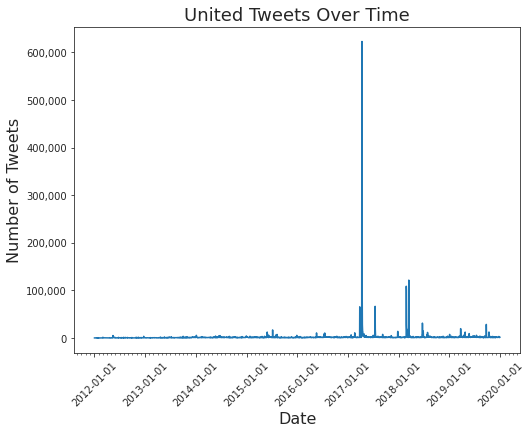

In [ ]:
plot_time_series(united_tweets['DATE'], united_tweets['COUNT'], 'United Tweets Over Time', 'Date', 'Number of Tweets')

Esa es una anomalía increíblemente grande. Vamos a ver.

### Desafio 5

#### 5.1

Investiga la anomalía. ¿Puedes explicar lo que pasó?

In [ ]:
united_tweets[united_tweets['COUNT'] > 300000]

COUNT       DATE  YEAR  MONTH
1926  595991 2017-04-10  2017      4
1927  622867 2017-04-11  2017      4

Una revisión rápida de Google mostrará que United tuvo un incidente notorio el 10 de abril de 2017.

#### 5.2

¿Cómo debemos manejar la anomalía?

**Respuesta.** Deberíamos realizar algún tipo de suavizado sobre la serie temporal. Hay muchos tipos de suavizado que podemos hacer:

1. Simplemente elimine las anomalías o reemplácelas con el valor esperado.
2. Podemos aplicar una media "móvil". es decir, tome el recuento promedio de los últimos 30 días. Incluso podríamos aplicar la mediana en lugar de la media.
3. Agregue los datos por mes

Todas estas son opciones excelentes, pero tendremos que medir objetivamente cuál es la mejor.

### Feature engineering our Twitter data (25 min)

Antes de comenzar con la ingeniería de funciones, necesitamos una forma de cuantificar la utilidad de lo que estamos tratando de lograr. En este caso, buscamos una señal que esté altamente correlacionada con los datos de pasajeros de United. Aunque nuestro objetivo es predecir los ingresos, la idea general es usar los datos de los pasajeros para predecir los ingresos y luego usar los datos de Twitter para predecir los datos más recientes de los pasajeros. Por lo tanto, usaremos nuestra funcion ```time_series_corr()``` en nuestra función diseñada y los datos mensuales de pasajeros para cuantificar su utilidad.

Primero, comenzaremos con un promedio móvil simple de los últimos treinta días. Usaremos `pandas` [```rolling()```](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html) . La funcion ```rolling()``` es bastante similar a ```groupby()```. Básicamente, "agrupa" las filas de forma continua:

In [ ]:
n_days = 30

united_tweets['SMA'] = united_tweets['COUNT'].rolling(n_days).mean()
united_tweets

COUNT       DATE  YEAR  MONTH          SMA
0       153 2012-01-01  2012      1          NaN
1       209 2012-01-02  2012      1          NaN
2       223 2012-01-03  2012      1          NaN
3       225 2012-01-04  2012      1          NaN
4       168 2012-01-05  2012      1          NaN
...     ...        ...   ...    ...          ...
2917   1931 2019-12-27  2019     12  1719.200000
2918   1374 2019-12-28  2019     12  1727.300000
2919   1441 2019-12-29  2019     12  1752.600000
2920   1622 2019-12-30  2019     12  1769.566667
2921   1712 2019-12-31  2019     12  1758.866667

[2922 rows x 5 columns]

Miremos si esto resuelve el problema

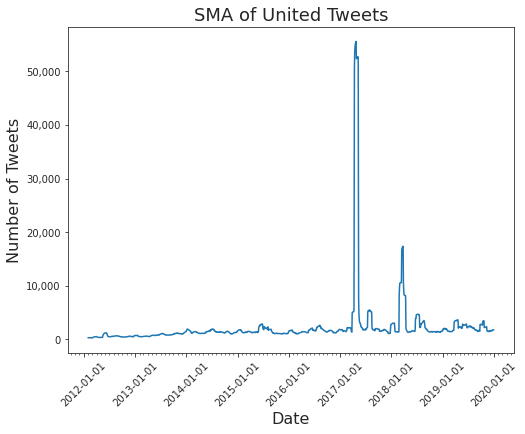

array([[ 1.        , -0.01396179],
       [-0.01396179,  1.        ]])

In [ ]:
plot_time_series(united_tweets['DATE'].iloc[n_days:], united_tweets['SMA'].iloc[n_days:], 'SMA of United Tweets', 'Date', 'Number of Tweets')

# Convertir 
time_series_corr(united_tweets.iloc[n_days:].groupby(['YEAR', 'MONTH']).mean()['SMA'], united_passengers_by_month['PASSENGERS'])

Lo bueno de la función ```rolling()```es que le permite aplicar diferentes pesos a la ventana movil. Por ejemplo, si desea favorecer los puntos de datos más recientes, todo lo que tiene que hacer es proporcionar el argumento ```win_type```. Consulte el enlace de documentación anterior para conocer todos los diferentes tipos de ventanas. O puede usar el [```ewm()```](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html) un promedio exponencial suavizado:

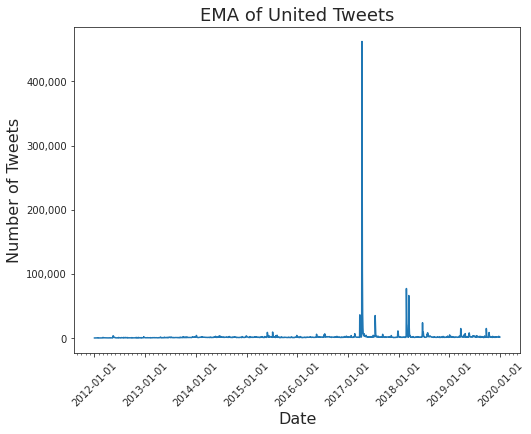

array([[ 1.        , -0.05028845],
       [-0.05028845,  1.        ]])

In [ ]:
alpha = 0.5
united_tweets['EMA'] = united_tweets['COUNT'].ewm(alpha=alpha).mean()
plot_time_series(united_tweets['DATE'], united_tweets['EMA'], 'EMA of United Tweets', 'Date', 'Number of Tweets')


time_series_corr(united_tweets.groupby(['YEAR', 'MONTH']).mean()['EMA'], united_passengers_by_month['PASSENGERS'])

Como puede ver, esto sigue siendo decepcionante. La causa principal es el fuerte aumento en 2017. ¿Existe otra función de agregación que sea más severa para los grandes picos? ¡Sí! La función mediana:

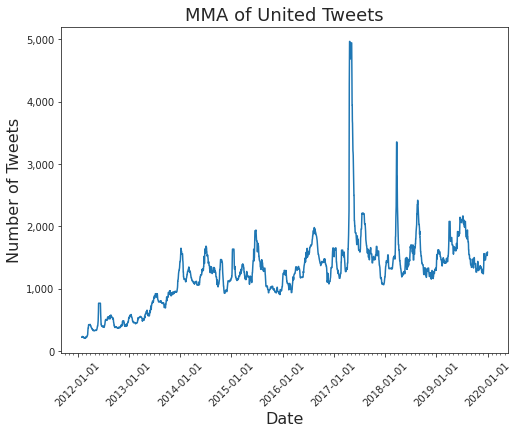

array([[1.        , 0.14861551],
       [0.14861551, 1.        ]])

In [ ]:
united_tweets['MMA'] = united_tweets['COUNT'].rolling(n_days).median()
plot_time_series(united_tweets['DATE'].iloc[n_days:], united_tweets['MMA'].iloc[n_days:], 'MMA of United Tweets', 'Date', 'Number of Tweets')


time_series_corr(united_tweets.iloc[n_days:].groupby(['YEAR', 'MONTH']).mean()['MMA'], united_passengers_by_month['PASSENGERS'])

¡Ahora estamos progresando! Pero los picos siguen siendo problemáticos. Si aplicamos la mediana en un rango mayor, los picos desaparecen:

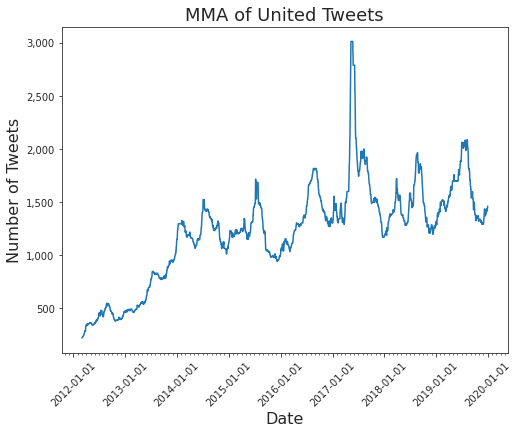

In [ ]:
n_days = 60
united_tweets['MMA'] = united_tweets['COUNT'].rolling(n_days).median()

plot_time_series(united_tweets['DATE'].iloc[n_days:], united_tweets['MMA'].iloc[n_days:], 'MMA of United Tweets', 'Date', 'Number of Tweets')

Sin embargo, el problema es que estamos limitados por el tamaño de la ventana porque entonces comenzamos a perder información de las estaciones. Una cosa fácil que podemos hacer es tomar la mediana de la mediana móvil:

In [ ]:
n_days = 30
united_tweets['MMA'] = united_tweets['COUNT'].rolling(n_days).median()

time_series_corr(united_tweets.iloc[n_days:].groupby(['YEAR', 'MONTH']).median()['MMA'], united_passengers_by_month['PASSENGERS'])

array([[1.        , 0.20493507],
       [0.20493507, 1.        ]])

Una vez más, algunos avances, pero los picos aún deben tratarse. ¿Qué pasa si primero agrupamos por mes en lugar de hacer una ventana móvil ?:

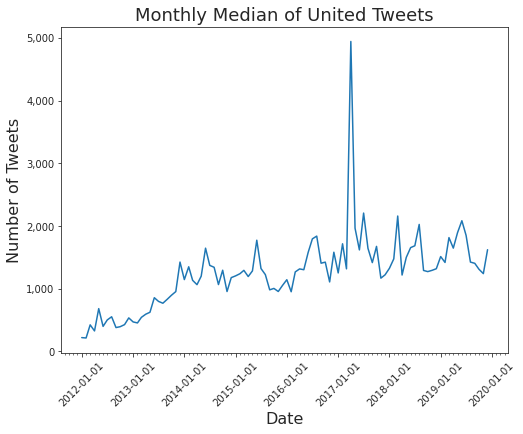

array([[1.       , 0.1120301],
       [0.1120301, 1.       ]])

In [ ]:
united_tweets_by_month = united_tweets.groupby(['YEAR', 'MONTH'])['COUNT'].median().reset_index()
plot_time_series(united_passengers_by_month['DATE'], united_tweets_by_month['COUNT'], 'Monthly Median of United Tweets', 'Date', 'Number of Tweets')
time_series_corr(united_tweets_by_month['COUNT'], united_passengers_by_month['PASSENGERS'])

Eso es un paso atrás, pero sigue siendo un esfuerzo valiente.

### Desafio 6

Intente diseñar la serie temporal de los tweets para eliminar los picos grandes y superar la correlación de $0.2$ que arrojó la ventana móvil mediana.

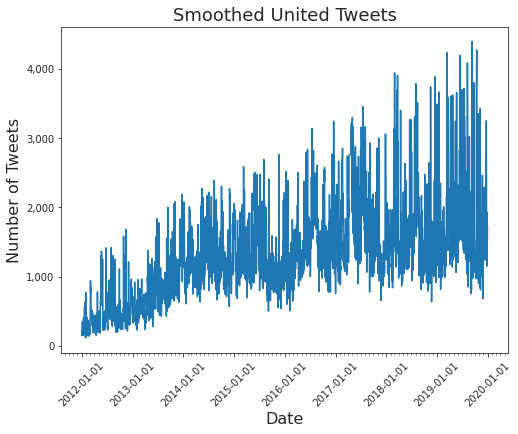

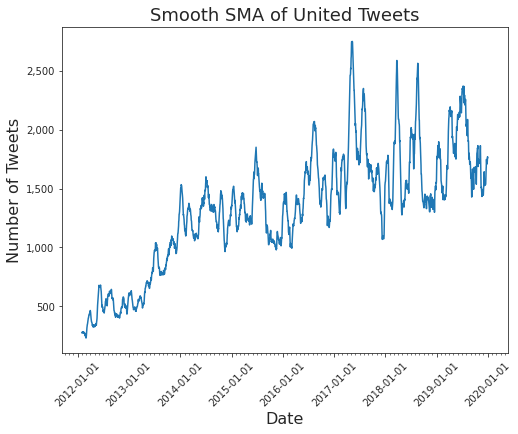

array([[1.        , 0.29176428],
       [0.29176428, 1.        ]])

In [ ]:
n_days = 30
slope, coef = np.polyfit(united_tweets.index, united_tweets['COUNT'], 1)
std = united_tweets['COUNT'].std()

def smooth_count(r):
    count = r['COUNT']
    t = r.name
    
    if count > t*slope + coef + 0.05*std:
        return t*slope + coef
    else:
        return count


united_tweets['SMOOTH_COUNT'] = united_tweets.apply(lambda r: smooth_count(r), axis=1)

plot_time_series(united_tweets['DATE'], united_tweets['SMOOTH_COUNT'], 'Smoothed United Tweets', 'Date', 'Number of Tweets')

# Aplicar rolling median
united_tweets['SMOOTH_SMA'] = united_tweets['SMOOTH_COUNT'].rolling(n_days).mean()
plot_time_series(united_tweets['DATE'].iloc[n_days:], united_tweets['SMOOTH_SMA'].iloc[n_days:], 'Smooth SMA of United Tweets', 'Date', 'Number of Tweets')

# Necesito convertir tweets al mes.
united_tweets_by_month = united_tweets.iloc[n_days:].groupby(['YEAR', 'MONTH']).mean()['SMOOTH_SMA'].reset_index()
time_series_corr(united_tweets_by_month['SMOOTH_SMA'], united_passengers_by_month['PASSENGERS'])

Una correlacion de $0.29$, no tan mal!

## Crear modelo 

**Variables Dependientes:**

1. Airlines passengers: hasta 3 meses atras- ```united_passengers_by_month```
2. Airlines costs: 3 meses atras- ```united_costs```
3. Oil costs: presente - ```oil_prices```
4. Tweet count: presente - ```united_tweets_by_month```

**Variable respuesta:**

1. Revenues: Disponible por quaternalmente

Todo es una serie de tiempo, por lo que debemos decidir cuánto historial queremos introducir en el algoritmo. Tener más historial debería ayudar con mejores predicciones, pero la mayor parte de la información útil se encuentra en el historial cercano. También tenemos que decidir qué variables incluir. A continuación, se muestran dos ejemplos:

$Revenue_i = f(Passengers_{i-3}, Costs_{i-2}, Kerosene_i, Tweets_i)$

Esto representa usar solo los últimos pasajeros, costos y tweets. En el otro extremo del espectro podríamos tener algo como:

$Revenue_i = f(Passengers_{i-3}, Passengers_{i-4}, Passengers_{i-5}, Passengers_{i-6}, Passengers_{i-7}, Passengers_{i-8}, Passengers_{i-9}, Passengers_{i-10}, Passengers_{i-11}, Passengers_{i-12}, Passengers_{i-13}, Passengers_{i-14}, Costs_{i-2}, Costs_{i-3}, Costs_{i-4}, Costs_{i-5}, Costs_{i-6}, Costs_{i-7}, Costs_{i-8}, Costs_{i-9}, Costs_{i-10}, Costs_{i-11}, Costs_{i-12}, Costs_{i-13}, Costs_{i-14}, Kerosene_{i}, Kerosene_{i-1}, Kerosene_{i-2}, Kerosene_{i-3}, Kerosene_{i-4}, Kerosene_{i-5}, Kerosene_{i-6}, Kerosene_{i-7}, Kerosene_{i-8}, Kerosene_{i-9}, Kerosene_{i-10}, Kerosene_{i-11}, Tweets_{i}, Tweets_{i-1}, Tweets_{i-2}, Tweets_{i-3}, Tweets_{i-4}, Tweets_{i-5}, Tweets_{i-6}, Tweets_{i-7}, Tweets_{i-8}, Tweets_{i-9}, Tweets_{i-10}, Tweets_{i-11})$

que incluiría los últimos 12 meses de datos para cada serie de tiempo que tenemos. Evaluemos ambos modelos. Primero tenemos que introducir las **lagged variables** en nuestro dataset usando la funcion`pandas` ```shift()```:

In [ ]:
oil_prices[['KEROSENE_PRICE']]

KEROSENE_PRICE
0             0.540
1             0.515
2             0.494
3             0.535
4             0.791
..              ...
352           1.800
353           1.874
354           1.861
355           1.824
356           1.893

[357 rows x 1 columns]

In [ ]:
oil_prices[['KEROSENE_PRICE']].shift(1)

KEROSENE_PRICE
0               NaN
1             0.540
2             0.515
3             0.494
4             0.535
..              ...
352           1.913
353           1.800
354           1.874
355           1.861
356           1.824

[357 rows x 1 columns]


Finalmente, tenemos que fusionar estos DataFrames rezagados con nuestra variable objetivo y hacer variables ficticias para los trimestres de la declaración de ingresos. Aquí se utilizan variables ficticias porque los cuartos no son ordinales. Es decir, si el efecto de los ingresos en el primer trimestre es $\beta$, entonces el efecto en el cuarto trimestre **no** será $ 4 \beta$:

In [ ]:
def make_lag_dfs(num_oil_lag, num_passengers_lag, num_costs_lag, num_tweets_lag):
    X = pd.DataFrame()

    start_date = datetime(2012,1,1)
    end_date = datetime(2020,1,1)

    X = oil_prices[(oil_prices['DATE'] >= start_date) & (oil_prices['DATE'] <= end_date)]

    # oil price lag

    for i in range(num_oil_lag):
        name = f"KEROSENE_PRICE_{i}"
        X[name] = X['KEROSENE_PRICE'].shift(i)

    del X['KEROSENE_PRICE']

    # passengers lag
    columns_to_keep = ['YEAR', 'MONTH', 'PASSENGERS']

    X = X.merge(united_passengers_by_month[
        (united_passengers_by_month['DATE'] >= start_date) & (united_passengers_by_month['DATE'] <= end_date)]
                [columns_to_keep], on=['YEAR', 'MONTH'], how='outer')

    for i in range(3, 3+num_passengers_lag):
        name = f"PASSENGERS_{i}"
        X[name] = X['PASSENGERS'].shift(i)

    del X['PASSENGERS']

    # costs lag
    columns_to_keep = ['YEAR', 'MONTH', 'TOTAL_COST']

    X = X.merge(united_costs[(united_costs['DATE'] >= start_date) & (united_costs['DATE'] <= end_date)]
                [columns_to_keep], on=['YEAR', 'MONTH'], how='outer')

    for i in range(3, 3+num_costs_lag):
        name = f"TOTAL_COST_{i}"
        X[name] = X['TOTAL_COST'].shift(i)

    del X['TOTAL_COST']

    # tweets lag
    columns_to_keep = ['YEAR', 'MONTH', 'SMOOTH_SMA']

    X = X.merge(united_tweets_by_month[columns_to_keep], on=['YEAR', 'MONTH'], how='outer')

    for i in range(num_tweets_lag):
        name = f"TWEETS_{i}"
        X[name] = X['SMOOTH_SMA'].shift(i)

    del X['SMOOTH_SMA']
    
    columns_to_keep = ['YEAR', 'MONTH', 'REVENUE']
    X = pd.merge(X, united_revenues[columns_to_keep], on=['YEAR', 'MONTH'])
    
    X = X.dropna()
    
    dates = X.apply(lambda r: datetime(r['YEAR'], r['MONTH'], 30) , axis=1)
    del X['DATE']
    del X['YEAR']
    
    X = pd.get_dummies(X, columns=['MONTH'])

    y = X['REVENUE']
    del X['REVENUE']

    return X, y, dates

X_minimal, y_minimal, dates_minimal = make_lag_dfs(1, 1, 1, 1)
X_maximal, y_maximal, dates_maximal = make_lag_dfs(12, 12, 12, 12)

In [ ]:
X_minimal.head()

KEROSENE_PRICE_0  PASSENGERS_3  TOTAL_COST_3  ...  MONTH_6  MONTH_9  MONTH_12
1             2.678     5952399.0   933220245.0  ...        1        0         0
2             3.191     6188615.0   855369144.0  ...        0        1         0
3             2.940     5271258.0   868453153.0  ...        0        0         1
4             2.969     5258843.0   791441194.0  ...        0        0         0
5             2.769     5647678.0   854589487.0  ...        1        0         0

[5 rows x 8 columns]

In [ ]:
X_maximal.head()

KEROSENE_PRICE_0  KEROSENE_PRICE_1  ...  MONTH_9  MONTH_12
4             2.969             3.218  ...        0         0
5             2.769             2.725  ...        0         0
6             2.934             3.003  ...        1         0
7             2.955             2.830  ...        0         1
8             2.890             2.965  ...        0         0

[5 rows x 52 columns]

Como podemos ver, el precio que paga por 12 meses de datos históricos son 3 puntos de datos, lo cual es bastante significativo para 30 puntos de datos generales. Para evaluar el rendimiento, entrenaremos de 2012 a 2018 y predeciremos los últimos 3 puntos de datos en 2019. El modelo con el que comenzaremos es un modelo lineal simple. Convirtamos también la variable del mes en una variable ficticia, ya que sabemos que no debe tratarse como un ordinal:

In [ ]:
dates_train = dates_minimal[:-3]
dates_test = dates_maximal[-3:]

X_train, y_train = X_minimal[:-3], y_minimal[:-3]
X_test, y_test = X_minimal[-3:], y_minimal[-3:]

clf = linear_model.LinearRegression()

clf.fit(X_train, y_train)

pred = clf.predict(X_train)
mean_error = (abs(pred-y_train)/y_train).mean()
standard_deviation = (abs(pred-y_train)/y_train).std()

print('Training Error:')

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

print('Test Error:')

pred = clf.predict(X_test)
mean_error = (abs(pred-y_test)/y_test).mean()
standard_deviation = (abs(pred-y_test)/y_test).std()

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

Training Error:
Mean Error: 0.023000193289723508
Standard Deviation of Error: 0.01676095013361506
Test Error:
Mean Error: 0.04553267140017184
Standard Deviation of Error: 0.0010661994746177037


Si bien los números no mienten, podemos ver claramente que el modelo máximo está sobreajustado:

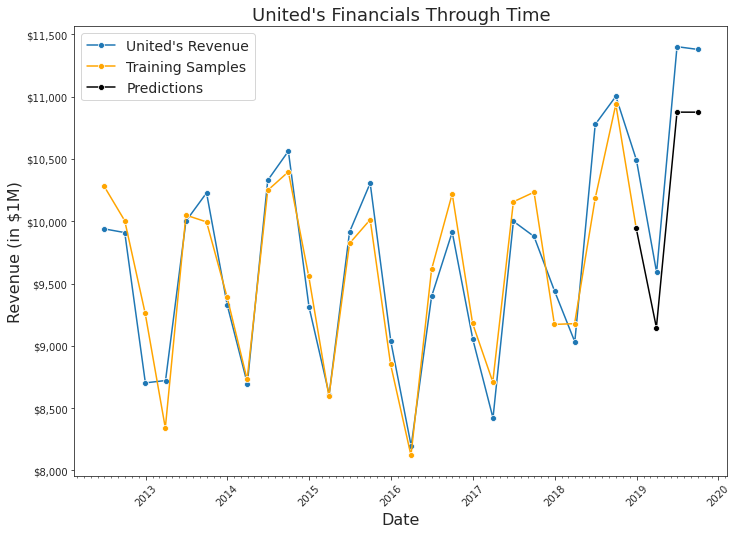

In [ ]:
def plot_prediction_time_series(dates_train, train, dates_test, pred, dates_truth, truth, title, x_label, y_label):
   
    years_locator = mdates.YearLocator()
    months_locator = mdates.MonthLocator()
    years_format = mdates.DateFormatter('%Y')
    
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)

    ax.ticklabel_format(axis='y', style='plain')

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

    ax.xaxis.set_major_locator(years_locator)
    ax.xaxis.set_major_formatter(years_format)
    ax.xaxis.set_minor_locator(months_locator)

    sns.lineplot(x=dates_truth, y=truth, marker='o')
    sns.lineplot(x=dates_train, y=train, color='orange', marker='o')

    dates_pred = list(dates_train[-1:]) + list(dates_test)
    plot_pred = list(train[-1:]) + list(pred)

    sns.lineplot(x=dates_pred, y=plot_pred, color='black', marker='o')

    plt.legend(labels=['United\'s Revenue', 'Training Samples', 'Predictions'], fontsize='14')

    rotation = 45
    plt.setp(ax.get_xticklabels(), rotation=rotation)
    plt.title('United\'s Financials Through Time', fontsize='18')
    plt.xlabel('Date', fontsize='16')
    plt.ylabel('Revenue (in $1M)', fontsize='16')

    plt.show()
    
plot_prediction_time_series(dates_train, clf.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')


In [ ]:
dates_train = dates_maximal[:-3]
dates_test = dates_maximal[-3:]

X_train, y_train = X_maximal[:-3], y_maximal[:-3]
X_test, y_test = X_maximal[-3:], y_maximal[-3:]

clf = linear_model.LinearRegression()
clf.fit(X_train, y_train)

pred = clf.predict(X_train)
mean_error = (abs(pred-y_train)/y_train).mean()
standard_deviation = (abs(pred-y_train)/y_train).std()

print('Training Error:')

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

print('Test Error:')

pred = clf.predict(X_test)
mean_error = (abs(pred-y_test)/y_test).mean()
standard_deviation = (abs(pred-y_test)/y_test).std()

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

Training Error:
Mean Error: 5.670347676842738e-16
Standard Deviation of Error: 3.1463872717599397e-16
Test Error:
Mean Error: 0.033087192248241575
Standard Deviation of Error: 0.01671403512223151


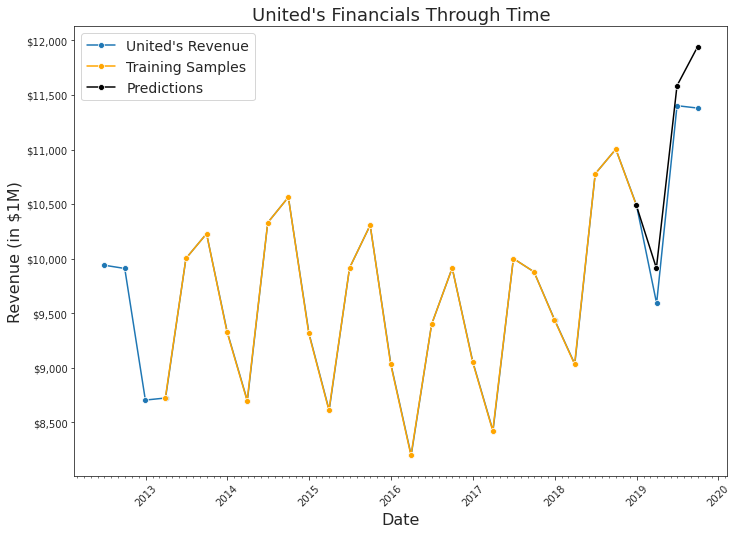

In [ ]:
plot_prediction_time_series(dates_train, clf.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')


Como puede ver, arrojar todas las variables al problema en realidad hace que el modelo se sobreajuste al realizar un seguimiento perfecto de la fecha de entrenamiento. Ahora, podemos ver que nuestro límite inferior para el rendimiento del modelo es algo así como el 3% en la fecha de la prueba. Todavía hay mucho trabajo que podría hacerse aquí, como considerar términos de interacción y otros modelos.

### Desafio 7

Cree su mejor modelo para predecir los ingresos futuros. No olvide que puede usar la funcion```make_lag_dfs()``` para darle el DataFrame adecuado con las variables rezagadas y variables ficticias del trimestre.

**Respuesta.** Continuando con el tema del sobreajuste, aquí hay un modelo que lo hace atrozmente:

Training Error:
Mean Error: 0.0002096832211651973
Standard Deviation of Error: 0.00013434294125796447
Test Error:
Mean Error: 0.28744612239806466
Standard Deviation of Error: 0.05663304831896096


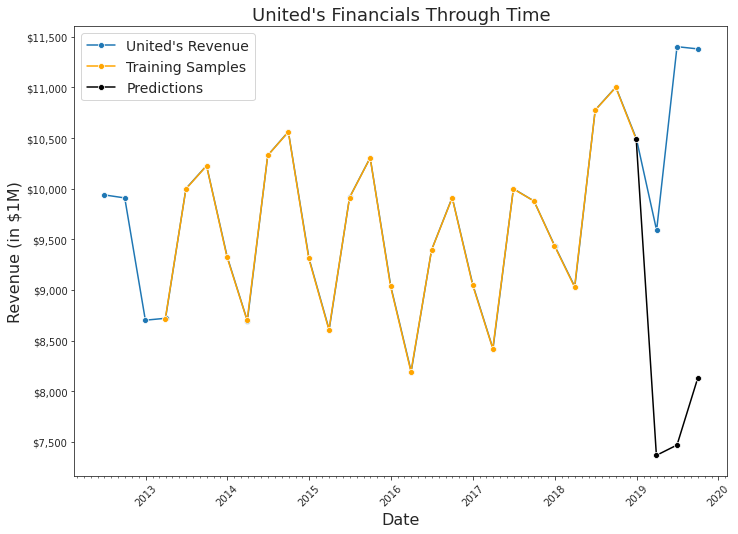

In [ ]:
from sklearn.kernel_ridge import KernelRidge

dates_train = dates_maximal[:-3]
dates_test = dates_maximal[-3:]

X_train, y_train = X_maximal[:-3], y_maximal[:-3]
X_test, y_test = X_maximal[-3:], y_maximal[-3:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

clf = GridSearchCV(KernelRidge(kernel='rbf'), param_grid={'alpha': np.logspace(0, -3, 10)})

clf.fit(X_train, y_train)

pred = clf.predict(X_train)
mean_error = (abs(pred-y_train)/y_train).mean()
standard_deviation = (abs(pred-y_train)/y_train).std()

print('Training Error:')

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

print('Test Error:')

pred = clf.predict(X_test)
mean_error = (abs(pred-y_test)/y_test).mean()
standard_deviation = (abs(pred-y_test)/y_test).std()

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

plot_prediction_time_series(dates_train, clf.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')

En términos de selección automática de características, podemos optar por la regresión LASSO con una búsqueda de cuadrícula:

Training Error:
Mean Error: 0.0012138554060361721
Standard Deviation of Error: 0.000737629941026297
Test Error:
Mean Error: 0.016557951404822458
Standard Deviation of Error: 0.012355234726724465


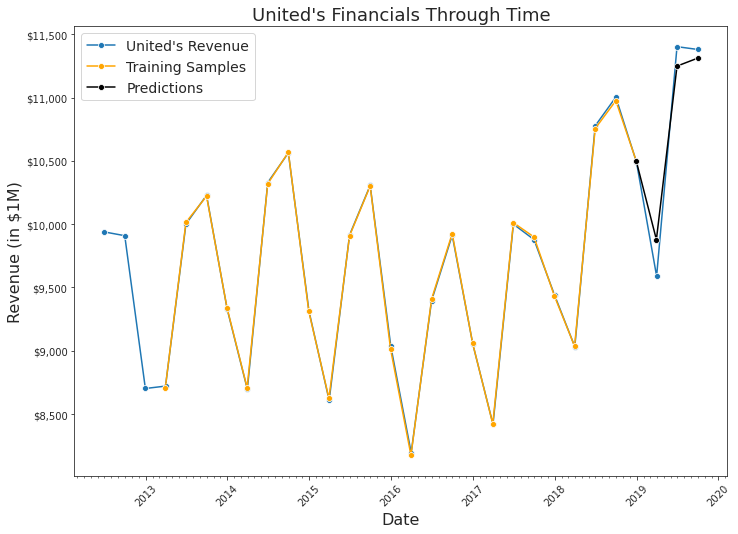

In [ ]:
X, y, dates = make_lag_dfs(0,12,12,12)

dates_train = dates[:-3]
dates_test = dates[-3:]

X_train, y_train = X[:-3], y[:-3]
X_test, y_test = X[-3:], y[-3:]

clf = GridSearchCV(linear_model.Lasso(), param_grid={'alpha': np.logspace(-3, 3, 10)})

clf.fit(X_train, y_train)

pred = clf.predict(X_train)
mean_error = (abs(pred-y_train)/y_train).mean()
standard_deviation = (abs(pred-y_train)/y_train).std()

print('Training Error:')

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

print('Test Error:')

pred = clf.predict(X_test)
mean_error = (abs(pred-y_test)/y_test).mean()
standard_deviation = (abs(pred-y_test)/y_test).std()

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

plot_prediction_time_series(dates_train, clf.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')

Finally, this case study wouldn't be complete without validating the actual revenue for Q4 of 2019, which was $10.888 billion:

In [ ]:
new_row = pd.DataFrame([[2019, 12, 31, 10888, datetime(2019,12,31), 4]], columns=united_revenues.columns)
tmp = united_revenues.copy()
united_revenues = united_revenues.append(new_row)

X, y, dates = make_lag_dfs(0,12,12,12)
united_revenues = tmp.copy()

print(f"Prediccion final para Q4 2019 es: {clf.predict(X.iloc[-1:])[0]} vs. un valor esperado de 10888")

Prediccion final para Q4 2019 es: 10642.66739811425 vs. un valor esperado de 10888


Eso representa un error de aproximadamente el 2,2%; ¡No está mal para un modelo con solo 30 ejemplos de entrenamiento!

## Conclusión (5 min)

En este caso, hicimos un proyecto de ciencia de datos de principio a fin, desde recopilar datos y limpiarlos, visualizar los datos para validarlos, diseñar algunas características nuevas a partir de los datos y finalmente construir un modelo para completar la tarea de predecir aerolínea. ingresos. Vimos problemas comunes en cada paso:

1. Limpieza: error en los datos recogidos
2. Visualización: cómo visualizar datos complicados
3. Ingeniería de funciones: nuestros datos sin procesar debían transformarse cuidadosamente para producir una señal.
4. Predecir: sobreajuste (overfit)

En cada etapa, superamos el problema sin perder de vista el objetivo y teniendo en cuenta el panorama general. Al comprender nuestro problema y sus influencias en el mundo real, pudimos lograr un mejor resultado al final.

## Para llevar (5 min)

La ciencia de datos es mucho más que conocer los últimos métodos y herramientas del oficio. Si pregunta qué hace a un buen carpintero, no respondería con "alguien que sepa usar un martillo". Estos deberían ser los puntos en los que debería centrarse en este caso:

1. Primero comprenda su problema. Si no tiene un objetivo claro, se quedará vagando. Evalúe sus datos de acuerdo con su objetivo.

3. La ciencia de datos real requiere prueba y error. Incluso las mejores fuentes de datos cometen errores. Debe validar constantemente la entrada y la salida.

4. Visualizar datos es clave para comprender. Imagínese eliminar todos los gráficos de este caso y trabajar únicamente con métricas. Si bien son útiles, las métricas nunca serán tan reveladoras como las gráficas para comprender los mecanismos de falla.

5. Finalmente, el paso de modelado es posiblemente el paso más fácil y menos importante para el éxito del proyecto. Al ceñirnos a modelos lineales simples, pudimos lograr muy buenos resultados. Sin embargo, omitir los datos de Twitter por completo podría haber comprometido gravemente nuestros resultados.